In [1]:
PIANO_VAE_GENERATOR_MODEL_WEIGHTS_PATH = './piano models/piano_model_vae_weights'
DRUMS_GENERATOR_MODEL_WEIGHTS_PATH = './model02'
NOISES_FOLDER_PATH = './noises/'
VOCALS_FOLDER_PATH = './vocals/'

## Piano generator

In [2]:
import os

import glob
import pickle
import numpy
import pandas
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from pydub import AudioSegment
from collections import Counter
from music21 import converter, instrument, note, chord, stream
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow import keras
from keras import layers

In [3]:
latent_dim = 2

In [15]:
def get_notes(path):
    """ Get all the notes and chords from the midi files in the 'path' directory """
    notes = []

    print(len(glob.glob(path + '/*.mid')))
    for file in glob.glob(path + '/*.mid'):
        midi = converter.parse(file)


        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(
                        data,
                        reconstruction
                    ), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
def load_pretrained_network(network_input, n_vocab, weights_path):
    """ create the structure of the neural network """

    encoder_inputs = keras.Input(shape=(32, 256, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 64 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 64, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    model = VAE(encoder, decoder)

    # Load the weights to each node
    model.load_weights(weights_path)

    return model

In [7]:
def create_midi(prediction_output, 
                output_path,
                offset_step):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
#         offset += 0.5
#         offset += 1.75
        offset += offset_step

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=output_path)

In [8]:
def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

In [9]:
def onehot_initialization(a, ncols):
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

In [10]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 32
    network_input = []
    
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    ncols = max(max(network_input))+1
    ncols = ncols + (ncols%4)
    network_input = onehot_initialization(np.array(network_input), ncols)

    return network_input

In [11]:
def generate_piano_roll(weights_path, output_path):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input = prepare_sequences(notes, pitchnames, n_vocab)
    model = load_pretrained_network(network_input, n_vocab, weights_path)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    while True:
        inp = np.random.normal(0,1,size=(1, latent_dim))
        item = model.decoder.predict(inp)[0]
        prediction_output = []
        for i in item:
            predicted_note = i.flatten()
            index = predicted_note.argmax()
            result = int_to_note[index]
            prediction_output.append(result)

        n_unique_notes = len(Counter(prediction_output).keys())
        if n_unique_notes > 8:
            break
    
#     return prediction_output
    create_midi(prediction_output, output_path)

In [20]:
def generate_piano(model, output_path, offset_step=1.5):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input = prepare_sequences(notes, pitchnames, n_vocab)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    while True:
        inp = np.random.normal(0,1,size=(1, latent_dim))
        item = model.decoder.predict(inp)[0]
        prediction_output = []
        for i in item:
            predicted_note = i.flatten()
            index = predicted_note.argmax()
            result = int_to_note[index]
            prediction_output.append(result)

        n_unique_notes = len(Counter(prediction_output).keys())
        if n_unique_notes > 8:
            break
    
#     return prediction_output
    create_midi(prediction_output, output_path, offset_step=offset_step)

In [21]:
notes = get_notes('midi_songs')
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

network_input = prepare_sequences(notes, pitchnames, n_vocab)
model = load_pretrained_network(network_input, n_vocab, PIANO_VAE_GENERATOR_MODEL_WEIGHTS_PATH + '_02')

93


In [22]:
network_input.shape

(1868, 32, 256)

In [35]:
generate_piano(model, output_path='vae01_piano_14.mid', offset_step=1)

In [36]:
os.system('fluidsynth -ni Touhou.sf2 vae01_piano_14.mid -F vae01_piano_14.wav -r 44100')

0

## Drums generator

In [37]:
from datetime import datetime
import itertools
import json
import os
import shutil

import os

import glob
import pickle
import numpy
import pandas
from pydub import AudioSegment
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
import numpy as np

from data import *
from midi_util import array_to_midi, print_array

In [38]:
# All the pitches represented in the MIDI data arrays.
# TODO: Read pitches from pitches.txt file in corresponding midi array
# directory.
PITCHES = [36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 49, 50, 58, 59, 60, 61, 62, 63, 64, 66]
# The subset of pitches we'll actually use.
IN_PITCHES = [36, 38, 42, 58, 59, 61]#[36, 38, 41, 42, 47, 58, 59, 61]
# The pitches we want to generate (potentially for different drum kit)
OUT_PITCHES = IN_PITCHES#[54, 56, 58, 60, 61, 62, 63, 64]
# The minimum number of hits to keep a drum loop after the types of
# hits have been filtered by IN_PITCHES.
MIN_HITS = 8

In [39]:
NUM_HIDDEN_UNITS = 128
# The length of the phrase from which the predict the next symbol.
PHRASE_LEN = 64
# Dimensionality of the symbol space.
SYMBOL_DIM = 2 ** len(IN_PITCHES)
NUM_ITERATIONS = 2
BATCH_SIZE = 128

# VALIDATION_PERCENT = 0.1
VALIDATION_PERCENT = 0.001

BASE_DIR = './'

MIDI_IN_DIR = os.path.join(BASE_DIR, 'drums midi')

MODEL_OUT_DIR = os.path.join(BASE_DIR, 'models')
MODEL_NAME = 'drum_generator'
TRIAL_DIR = os.path.join(MODEL_OUT_DIR, MODEL_NAME)

MIDI_OUT_DIR = os.path.join(TRIAL_DIR, 'gen-midi')

In [40]:
encodings = {
    config : i
    for i, config in enumerate(itertools.product([0,1], repeat=len(IN_PITCHES)))
}

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = a.astype('float64')
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))


def encode(midi_array):
    '''Encode a folded MIDI array into a sequence of integers.'''
    return [
        encodings[tuple((time_slice>0).astype(int))]
        for time_slice in midi_array
    ]

decodings = {
    i : config
    for i, config in enumerate(itertools.product([0,1], repeat=len(IN_PITCHES)))
}

def decode(config_ids):
    '''Decode a sequence of integers into a folded MIDI array.'''
    velocity = 120
#     velocity = 1
    return velocity * np.vstack(
        [list(decodings[id]) for id in config_ids])

In [41]:
def unfold(midi_array, pitches):
    '''Unfold a folded MIDI array with the given pitches.'''
    # Create an array of all the 128 pitches and fill in the
    # corresponding pitches.
    res = np.zeros((midi_array.shape[0], 128))
    assert midi_array.shape[1] == len(pitches), 'Mapping between unequal number of pitches!'
    for i in range(len(pitches)):
        res[:,pitches[i]] = midi_array[:,i]
    return res

In [42]:
def prepare_data():
    # Load the data.
    # Concatenate all the vectorized midi files.
    num_steps = 0

    # Sequence of configuration numbers representing combinations of
    # active pitches.
    config_sequences = []
    num_dirs = len([x for x in os.walk(MIDI_IN_DIR)])
    assert num_dirs > 0, 'No data found at {}'.format(MIDI_IN_DIR)

    in_pitch_indices = [ PITCHES.index(p) for p in IN_PITCHES ]
    for dir_idx, (root, dirs, files) in enumerate(os.walk(MIDI_IN_DIR)):
        for filename in files:
            if filename.split('.')[-1] != 'npy':
                continue
            array = np.load(os.path.join(root, filename))
            if np.sum(np.sum(array[:, in_pitch_indices]>0)) < MIN_HITS:
                continue
            config_sequences.append(np.array(encode(array[:, in_pitch_indices])))
        print('Loaded {}/{} directories'.format(dir_idx + 1, num_dirs))


    return config_sequences

In [43]:
def init_model():
    # Build the model.
    model = Sequential()
    model.add(LSTM(
        NUM_HIDDEN_UNITS,
        return_sequences=True,
        input_shape=(PHRASE_LEN, SYMBOL_DIM)))
    model.add(Dropout(0.3))
    '''
    model.add(LSTM(
        NUM_HIDDEN_UNITS,
        return_sequences=True,
        input_shape=(SYMBOL_DIM, SYMBOL_DIM)))
    model.add(Dropout(0.2))
    '''
    model.add(LSTM(NUM_HIDDEN_UNITS, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(SYMBOL_DIM))
    model.add(Activation('softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=1e-03, rho=0.9, epsilon=1e-08))
    return model

In [44]:
def generate(model, seed, mid_name, temperature=1.0, length=512, tpq=1000):
    '''Generate sequence using model, seed, and temperature.'''

    generated = []
    phrase = seed

    if not hasattr(temperature, '__len__'):
        temperature = [temperature for _ in range(length)]

    for temp in temperature:
        x = np.zeros((1, PHRASE_LEN, SYMBOL_DIM))
        for t, config_id in enumerate(phrase):
            x[0, t, config_id] = 1
        preds = model.predict(x, verbose=0)[0]
        next_id = sample(preds, temp)

        generated += [next_id]
        phrase = phrase[1:] + [next_id]

    # ticks per quarter has negative correlation with drums speed
    mid = array_to_midi(unfold(decode(generated), OUT_PITCHES), mid_name, ticks_per_quarter=tpq)
    mid.save(os.path.join(MIDI_OUT_DIR, mid_name))
    return mid

In [45]:
def generate_drums(model, config_sequences, output_path, tpq=1000):
    sequence_indices = idx_seq_of_length(config_sequences, PHRASE_LEN)
    seq_index, phrase_start_index = sequence_indices[
                np.random.choice(len(sequence_indices))]
    gen_length = 512
    for temperature in [0.75,0.5, 0.75, 1.0]:
        generated = []
        phrase = list(
            config_sequences[seq_index][
                phrase_start_index: phrase_start_index + PHRASE_LEN
            ]
        )

        print('----- Generating with temperature:', temperature)

        midi = generate(model,
                        phrase,
                        'out_{}_{}_{}.mid'.format(gen_length, temperature, 0),
                        temperature=temperature,
                        length=gen_length,
                        tpq=tpq)
        break
        
    midi.save(output_path)

In [46]:
config_sequences = prepare_data()

Loaded 1/1 directories


In [47]:
len(config_sequences), len(config_sequences[4])

(1161, 1536)

In [48]:
drums_model = init_model()
drums_model.load_weights(DRUMS_GENERATOR_MODEL_WEIGHTS_PATH)

In [57]:
generate_drums(drums_model, config_sequences, 'drums_05.mid')

----- Generating with temperature: 0.75


<ipython-input-40-45a54c43edaa>:8: RuntimeWarning: divide by zero encountered in log
  a = np.log(a) / temperature


In [58]:
os.system('fluidsynth -ni Touhou.sf2 drums_05.mid -F drums_05.wav -r 44100')

0

## Generate Piano roll & Drums line

In [303]:
def generate_lines():
    # generate piano roll midi file
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(set(notes))

    network_input = prepare_sequences(notes, pitchnames, n_vocab)
    model = load_pretrained_network(network_input, n_vocab, PIANO_VAE_GENERATOR_MODEL_WEIGHTS_PATH + '_02')
    generate_piano(model, output_path='piano_roll.mid', offset_step=1.5)
    
    # convert midi to wav format
    os.system('fluidsynth -ni Touhou.sf2 piano_roll.mid -F piano_roll.wav -r 44100')
    # delete piano roll midi file
    os.system('rm -f piano_roll.mid')
    
    # generate drums line midi file
    config_sequences = prepare_data()
    drums_model = init_model()
    drums_model.load_weights(DRUMS_GENERATOR_MODEL_WEIGHTS_PATH)
    generate_drums(drums_model, config_sequences, 'drums_line.mid', tpq=1100)
    # convert midi to wav format
    os.system('fluidsynth -ni Touhou.sf2 drums_line.mid -F drums_line.wav -r 44100')
    # delete drums line midi file
    os.system('rm -f drums_line.mid')

## Generate Lo-Fi

In [304]:
SECOND = 1000

In [305]:
def mix_lines(drums_line, piano_line, noise_line, vocal_line, music_len=60):
    drums_line = drums_line[5*SECOND : (music_len + 5)*SECOND]
    piano_line = piano_line[: music_len*SECOND]
    noise_line = noise_line[: music_len*SECOND]
    
    piano = piano_line.low_pass_filter(35)
    piano = piano + 18
    # piano = piano.low_pass_filter(110)
    drums = drums_line.low_pass_filter(115)
    drums = drums + 25
    noise = noise_line - 15
    vocal = vocal_line + 5
    
    piano = piano.fade_in(4*SECOND)
    noise = noise.fade_in(10*SECOND)
    
    music = noise.overlay(
        vocal, 
        position=4*SECOND
    ).overlay(
        piano, 
        position=10*SECOND
    ).overlay(
        drums, 
        position=15*SECOND
    )
    
    music = music.fade_out(8*SECOND)
    
    return music

In [30]:
SECOND = 1000

In [314]:
generate_lines()

Loaded 1/1 directories
----- Generating with temperature: 0.75


<ipython-input-17-45a54c43edaa>:8: RuntimeWarning: divide by zero encountered in log
  a = np.log(a) / temperature


In [315]:
drums_line = AudioSegment.from_wav('drums_line.wav')
piano_line = AudioSegment.from_wav('piano_roll.wav')

In [316]:
drums_line

In [317]:
piano_line * 3

In [318]:
noise_line = AudioSegment.from_mp3(NOISES_FOLDER_PATH + 'Storm.mp3')
vocal_line = AudioSegment.from_mp3(VOCALS_FOLDER_PATH + "say-hello-to-my-little-friend!.mp3")

In [336]:
music = mix_lines(
    (drums_line - 4) * 2,
    (piano_line - 5) * 3,
    noise_line - 2,
    vocal_line - 14,
    music_len=75
)

In [337]:
music

In [338]:
music.export('generated musics/generated_music_storm_hello.mp3')

<_io.BufferedRandom name='generated musics/generated_music_storm_hello.mp3'>

In [105]:
drums_line = AudioSegment.from_mp3('drums_line_filtered.mp3')

In [85]:
drums_line.export('drums_line_filtered2.wav')

<_io.BufferedRandom name='drums_line_filtered2.wav'>

In [245]:
drums_line = AudioSegment.from_wav('drums_line.wav')

In [246]:
drums_line = drums_line[3700:3850]
drums_line.export('drums_line3.wav', format='wav')

<_io.BufferedRandom name='drums_line3.wav'>

In [247]:
drums_line

In [248]:
drums = drums_line.low_pass_filter(80)
# drums = drums + 25

In [249]:
drums

In [250]:
drums.export('drums_line_filtered3.wav', format='wav')

<_io.BufferedRandom name='drums_line_filtered3.wav'>

In [251]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import wave, sys

# shows the sound waves
def visualize(path: str):

    raw = wave.open(path)
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")

    f_rate = raw.getframerate()

    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
    )

    plt.figure(figsize=(16,10))
    plt.title("Sound Wave")
    plt.xlabel("Time")
    plt.plot(time, signal)
    plt.show()


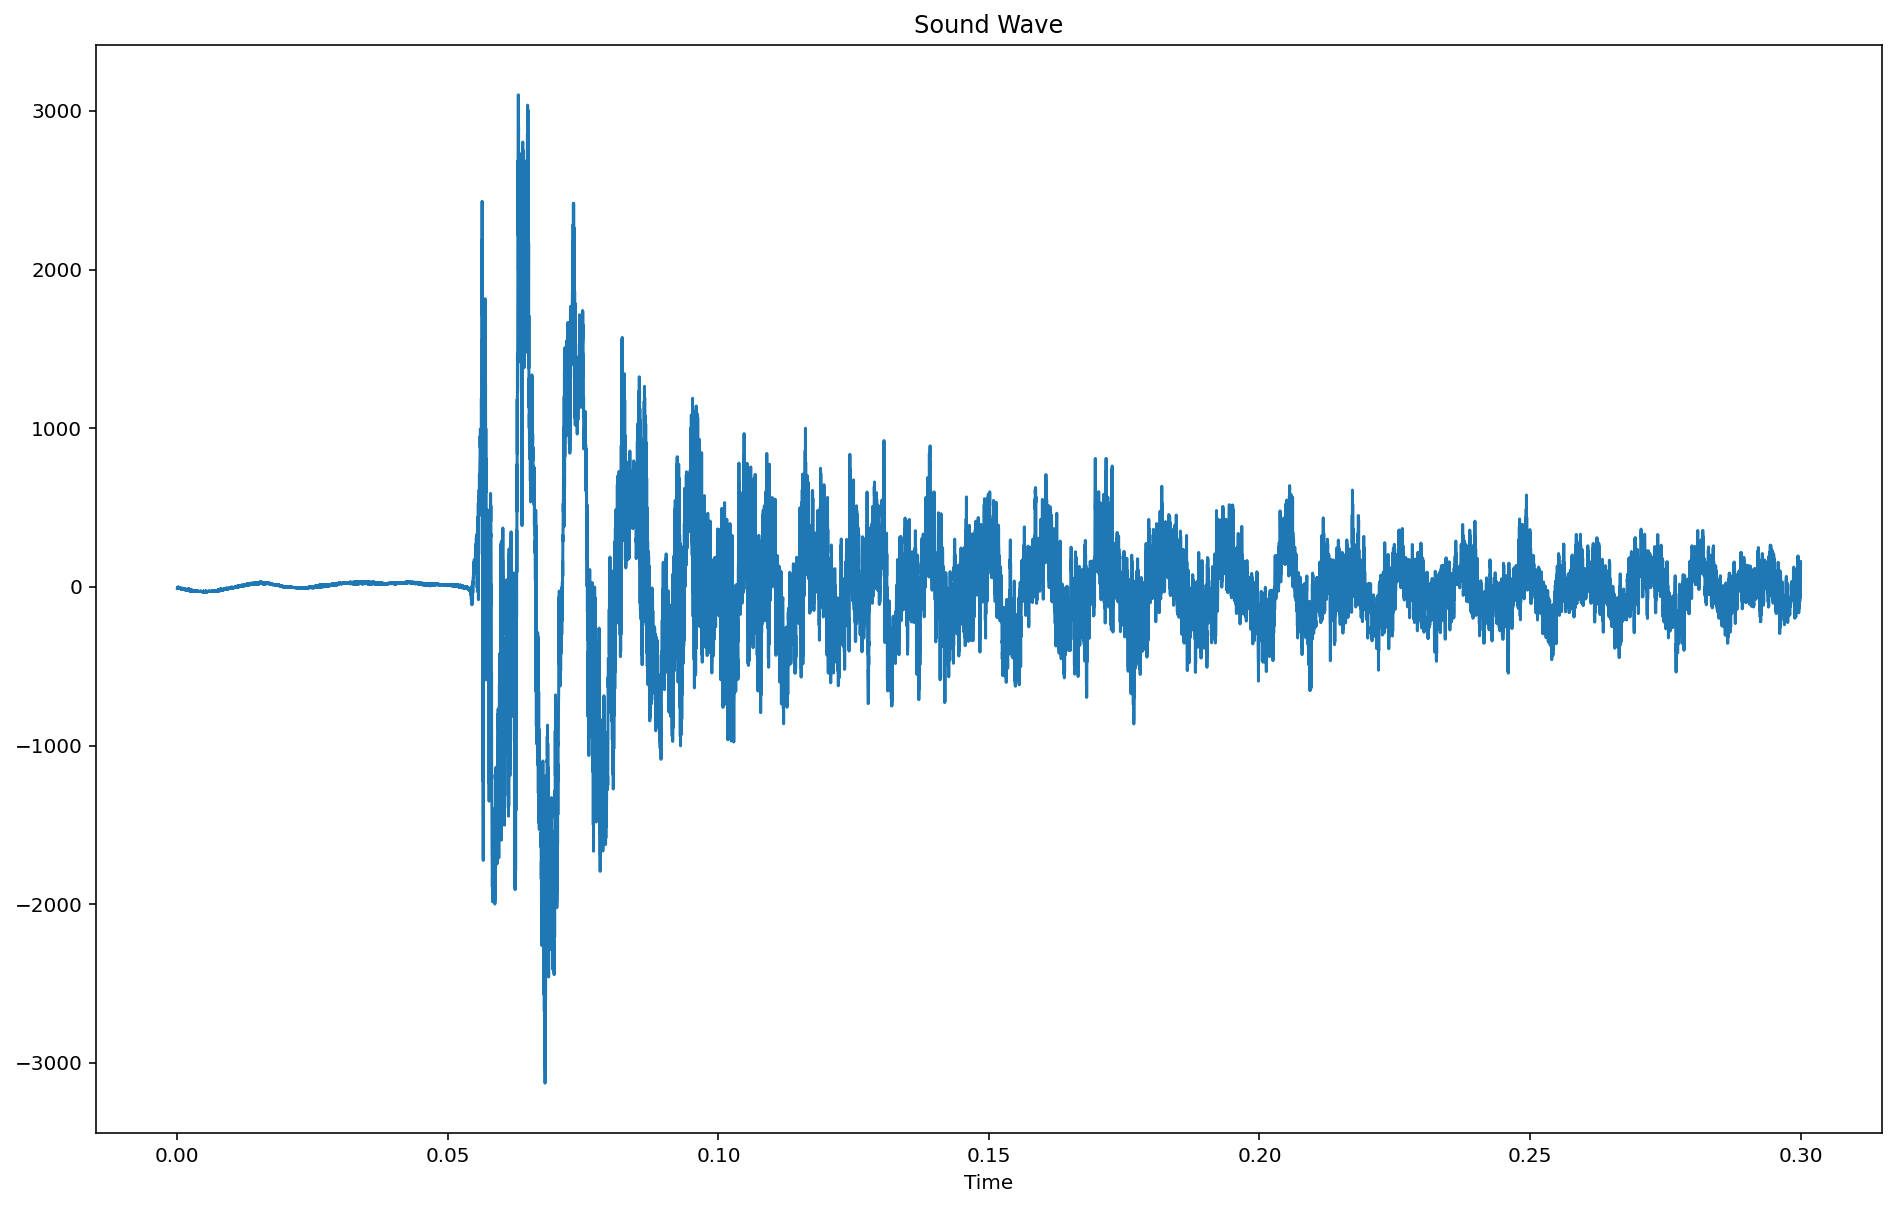

In [252]:
visualize('drums_line3.wav')

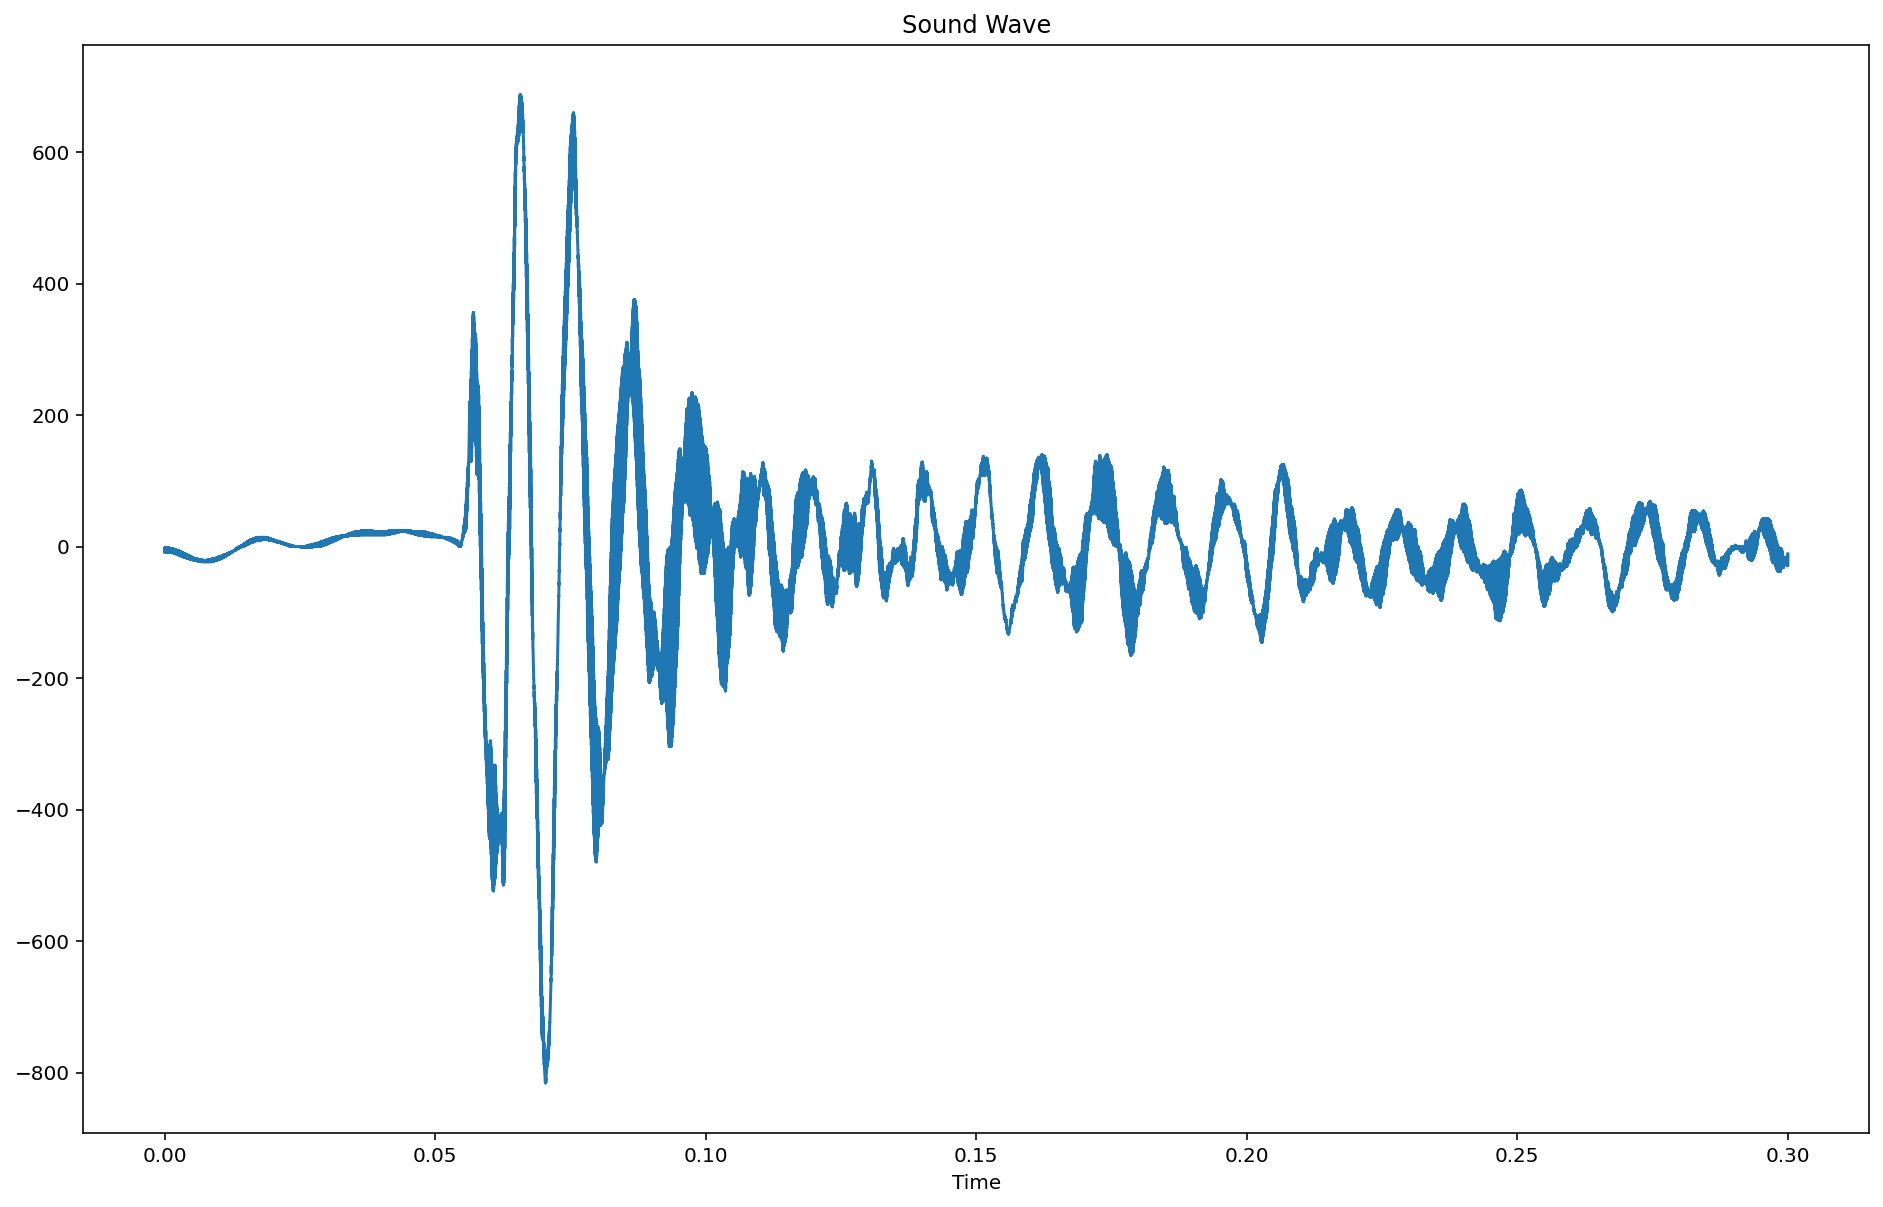

In [253]:
visualize('drums_line_filtered3.wav')

In [88]:
from scipy.io.wavfile import read

In [89]:
samplerate, data = read('drums_line_filtered.wav')

ValueError: File format b'ID3\x04' not understood. Only 'RIFF' and 'RIFX' supported.